## Inversion of an water-born survey over the river Leith
This study has been demonstrated in the EMagPy paper [McLachlan et al. (2021)](https://doi.org/10.1016/j.cageo.2020.104561).

EMI can be a useful tool to investigate the interface between surface water and ground-water. In this case, EMI measurements were collected with a CMD Explorer on a kayak above the river. Using prior knowledge of the bottom of the water, EMI data can be inverted. We can see here that area of higher EC correspond quite well with area of higher hydraulic heads ([Binley et al., 2013](https://doi.org/10.1002/wrcr.20214)). This is because the ground-water EC is higher than the river EC, so in this case, EMI help us to identify zone of ground-water upwelling.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys
sys.path.append('../src') # add path where emagpy is
from emagpy import Problem

datadir = '../src/examples/'

letters = ['a','b','c','d','e','f','g','h','i','j']

 14%|█████▋                                    | 16/117 [00:00<00:01, 92.45it/s]

dataset shrunk of 19 measurements


100%|█████████████████████████████████████████| 117/117 [02:14<00:00,  1.15s/it]


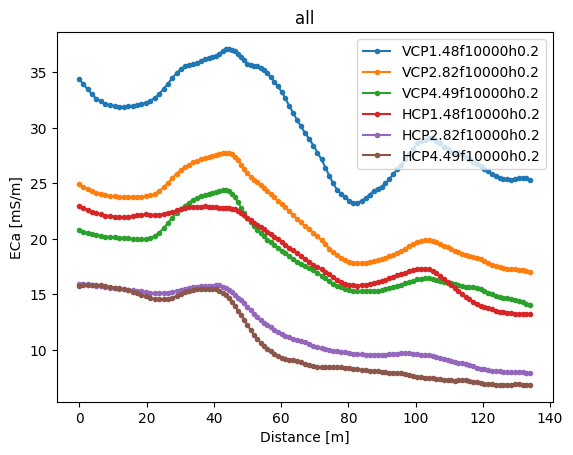

In [2]:
k = Problem()
k.createSurvey(datadir + 'leith/leith_emi_heads.csv')
k.surveys[0].df = k.surveys[0].df[::4].reset_index(drop=True)  # decimation for faster inversion
k.rollingMean(window=20)
wdepths = k.surveys[0].df['depth'].values # measured water depths
k.show(dist=True)
depths = wdepths[:,None] + np.arange(0, 3.1, 0.15)
conds0 = np.ones(depths.shape[1]+1)*20
fixedConds = np.zeros(depths.shape[1]+1, dtype=bool)
conds0[0] = 48 # river water EC measured (mS/m)
fixedConds[0] = True # river EC fixed
k.setInit(depths0=depths, conds0=conds0, fixedConds=fixedConds)
k.invert(forwardModel='FSlin', alpha=0.7, beta=0, njobs=-1) # beta > 0 will cause lateral smoothing
# In the paper, the corresponding Figure is produced using a lateral smoothing factor as in the line below
#k.invert(forwardModel='FSlin', alpha=0.7, beta=0.7) # beta > 0 will cause lateral smoothing

/tmp/ipykernel_43059/2960716780.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  current_cmap = mpl.cm.get_cmap() # set NaN as white


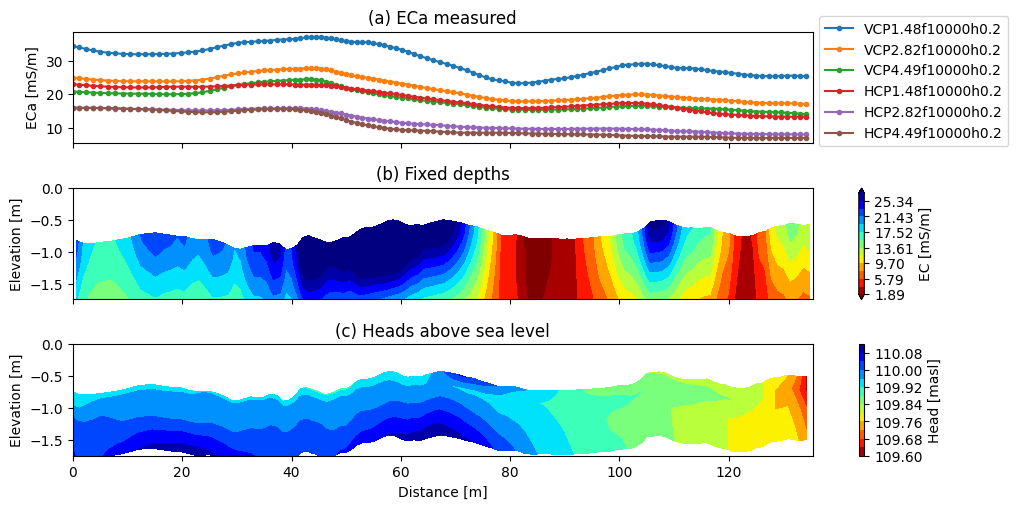

In [3]:
# figure
fig, axs = plt.subplots(3, 1, figsize=(12,5), sharex=True)
ax0 = axs[0]
ax1 = axs[1]
ax2 = axs[2]

k.show(ax=ax0, dist=True)
ax0.set_title('(a) ECa measured')
ax0.set_xlabel('')
ax0.get_legend().remove()
ax0.legend(k.coils, bbox_to_anchor=(1,1.2))

current_cmap = mpl.cm.get_cmap() # set NaN as white
current_cmap.set_bad(color='white')
k.models[0][:,0] = np.nan # blank river as it's fixed EC
k.showResults(ax=ax1, contour=True, dist=True, cmap='jet_r')
ax1.set_title('(b) Fixed depths')
ax1.set_xlabel('')
ax1.set_ylim([-1.75, 0])

ax2.set_title('(c) Heads above sea level')
df = k.surveys[0].df

xy = df[['x','y']].values
distance = np.sqrt(np.sum(np.diff(xy, axis=0)**2, axis=1))
distance = np.r_[[0], distance, distance[[-1]]]
x = np.cumsum(distance)
xx = np.ones((df.shape[0], 4))*x[:-1,None]
yy = np.ones((df.shape[0], 4))*df['depth'].values[:,None]
yy = yy + np.array([[0, 0.2, 0.5, 1]])

heads = df[['Stage(m)', 'H20cm(m)', 'H50cm(m)', 'H100cm(m)']].values
cax = ax2.contourf(xx, -yy, heads, cmap='jet_r', levels=15)
ax2.set_xlabel('Distance [m]')
ax2.set_ylabel('Elevation [m]')
ax2.set_ylim([-1.75, 0])
fig.colorbar(cax, ax=ax2, label='Head [masl]') # meter above sea level

# adjust the x axis of subplot 1 to match the others
pos1 = ax1.get_position()
pos2 = ax0.get_position()
ax0.set_position([pos1.x0,pos2.y0,pos1.width,pos2.height])

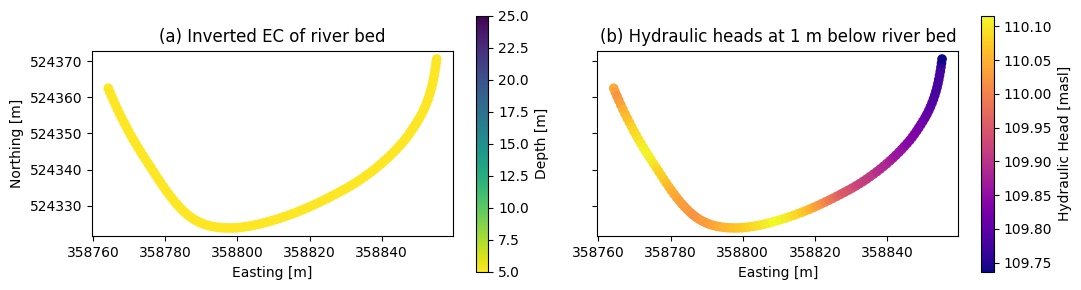

In [4]:
# figure of spatial data
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(11,3))
ax = axs[0]
k.showSlice(islice=-2, ax=ax, vmin=5, vmax=25)
ax.set_title('(a) Inverted EC of river bed')
ax.set_xlabel('Easting [m]')
ax.set_ylabel('Northing [m]')
ax.set_aspect('equal')
ax = axs[1]
ax.set_title('(b) Hydraulic heads at 1 m below river bed')
df = k.surveys[0].df
cax = ax.scatter(df['x'], df['y'], s=35, c=df['H100cm(m)'], cmap='plasma')
ax.set_xlabel('Easting [m]')
ax.set_aspect('equal')
fig.colorbar(cax, ax=ax, label='Hydraulic Head [masl]') # masl = meter above sea level
fig.tight_layout()